In [22]:
### Imports and Settings 
import datetime as dt
import sys
import numpy as np
from numpy import cumsum, log, polyfit, sqrt, std, subtract, mean
from numpy.random import randn
import pandas as pd
from pandas_datareader import data as web
import seaborn as sns
from pylab import rcParams 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from arch import arch_model
from numpy.linalg import LinAlgError
from scipy import stats
import statsmodels.api as sm
import statsmodels.tsa.api as tsa
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, q_stat, adfuller
from sklearn.metrics import mean_squared_error
from scipy.stats import probplot, moment
from arch import arch_model
from arch.univariate import ConstantMean, GARCH, Normal
from sklearn.model_selection import TimeSeriesSplit
from tabulate import tabulate
import warnings

In [2]:
%matplotlib inline
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')
sns.set(style="darkgrid", color_codes=True)
rcParams['figure.figsize'] = 8,4

In [3]:
def plot_correlogram(x, lags=None, title=None):    
    lags = min(10, int(len(x)/5)) if lags is None else lags
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
    x.plot(ax=axes[0][0])
    q_p = np.max(q_stat(acf(x, nlags=lags), len(x))[1])
    stats = f'Q-Stat: {np.max(q_p):>8.2f}\nADF: {adfuller(x)[1]:>11.2f}'
    axes[0][0].text(x=.02, y=.85, s=stats, transform=axes[0][0].transAxes)
    probplot(x, plot=axes[0][1])
    mean, var, skew, kurtosis = moment(x, moment=[1, 2, 3, 4])
    s = f'Mean: {mean:>12.2f}\nSD: {np.sqrt(var):>16.2f}\nSkew: {skew:12.2f}\nKurtosis:{kurtosis:9.2f}'
    axes[0][1].text(x=.02, y=.75, s=s, transform=axes[0][1].transAxes)
    plot_acf(x=x, lags=lags, zero=False, ax=axes[1][0])
    plot_pacf(x, lags=lags, zero=False, ax=axes[1][1])
    axes[1][0].set_xlabel('Lag')
    axes[1][1].set_xlabel('Lag')
    fig.suptitle(title, fontsize=20)
    fig.tight_layout()
    fig.subplots_adjust(top=.9)



# Data Setup
    -Getting Stock Data
    -Getting Irithmics Data

In [2]:
start = pd.Timestamp('2017-01-01')
end = pd.Timestamp('2020-12-31')

In [3]:
priceData = web.DataReader('LLOY.L', 'yahoo', start, end)\
      [['Close']]

In [4]:
#Storing the returns
priceData['pctReturn'] = 100*(priceData['Close'].pct_change())
priceData['logReturn'] = np.log(priceData['Close']).diff().mul(100)
priceData = priceData.dropna()

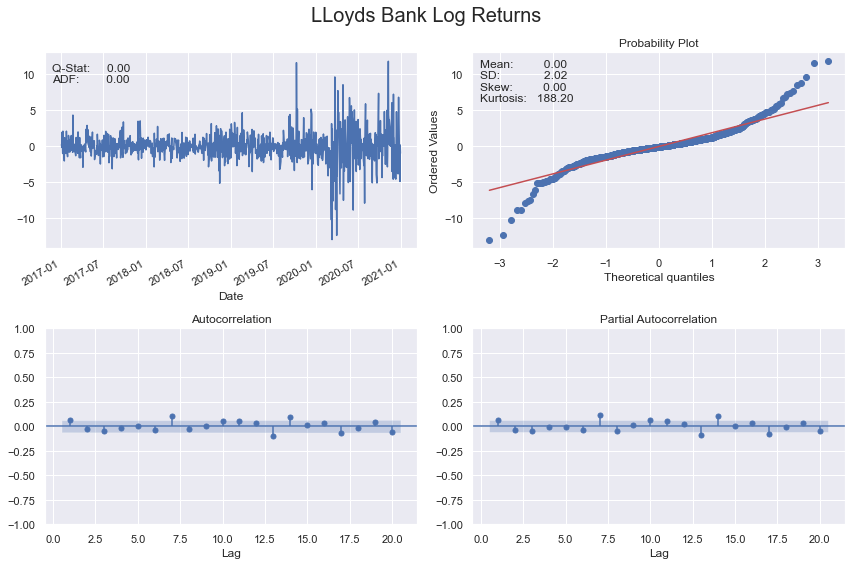

In [7]:
plot_correlogram(priceData['logReturn'], lags=20, title='LLoyds Bank Log Returns')

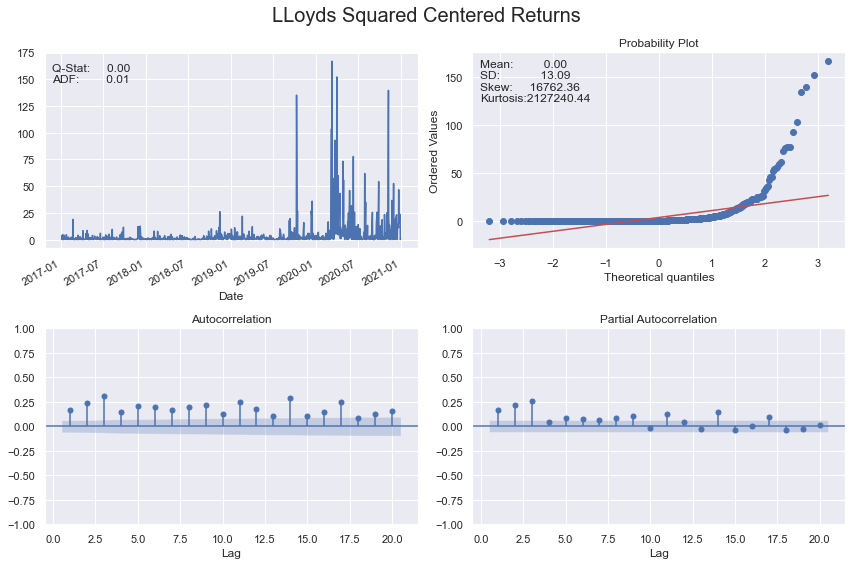

In [8]:
plot_correlogram(priceData['logReturn'].sub(priceData['logReturn'].mean()).pow(2)
                 , lags=20, title='LLoyds Squared Centered Returns')

In [9]:
# Calculate daily std of returns
std_daily = priceData['logReturn'].std()
print(f'Daily volatility: {round(std_daily,2)}%')

# Convert daily volatility to monthly volatility
std_monthly = np.sqrt(22) * std_daily
print(f'\nMonthly volatility: {round(std_monthly,2)}%')

# Convert daily volatility to annaul volatility
std_annual = np.sqrt(252) * std_daily
print(f'\nAnnual volatility: {round(std_annual,2)}%')

Daily volatility: 2.03%

Monthly volatility: 9.5%

Annual volatility: 32.15%


## Min AIC Search For Best GARCH Model
    -Brute force search idk how to optimize this better but whatever

In [46]:
aic = [0 for a in range(96)]
dist = [0 for a in range(96)]
model = [0 for a in range(96)]
vol = [0 for a in range(96)]
x = 0
for i in range(0,4):
    for j in range(0,4):
        for k in ['normal', 't', 'skewt', 'ged']:
            for l in ['GARCH', 'EGARCH']:
                if i == 0 & j == 0:
                    next
                else:
                    mdl = arch_model(priceData['logReturn'],
                                           p = i,
                                           q = j,
                                           mean = 'constant',
                                           vol = l,
                                           dist = k)
                    res = mdl.fit(disp = 'off')
                    #print(f'GARCH({j},{i}) {k} AIC: {res.aic}')
                    aic[x] = str(res.aic)
                    vol[x] = str(l)
                    dist[x] = str(k)
                    model[x] ='GARCH (%s, %s)' %(j,i)
                    x = x+1


In [47]:
aic, dist, model, vol = np.array(aic),np.array(dist),np.array(model), np.array(vol)
garchSearch = pd.DataFrame(model, columns = ['Model'])
garchSearch['Volatility'] = vol
garchSearch['Distribution'] = dist
garchSearch['AIC'] = aic.astype(float).round(2)

In [65]:
x = garchSearch.sort_values(by='AIC', ascending=True)
print(garchSearch.sort_values(by='AIC', ascending=True))

           Model Volatility Distribution      AIC
77  GARCH (1, 3)     EGARCH        skewt  3682.50
13  GARCH (1, 1)     EGARCH        skewt  3682.96
11  GARCH (1, 1)     EGARCH            t  3683.19
75  GARCH (1, 3)     EGARCH            t  3683.26
60  GARCH (3, 2)      GARCH        skewt  3683.46
..           ...        ...          ...      ...
32  GARCH (0, 2)      GARCH       normal  3957.44
65  GARCH (0, 3)     EGARCH       normal  3981.07
0   GARCH (0, 1)      GARCH       normal  4103.11
33  GARCH (0, 2)     EGARCH       normal  4104.47
1   GARCH (0, 1)     EGARCH       normal  4168.36

[96 rows x 4 columns]


In [73]:
test = pd.concat([x.head(5),pd.DataFrame({'Model': ["..."],
                    'Volatility': ["..."],
                    'Distribution': ["..."],
             "AIC": ["..."]}), test.tail(5)])

,Model,Volatility,Distribution,AIC
77,"GARCH (1, 3)",EGARCH,skewt,3682.50
13,"GARCH (1, 1)",EGARCH,skewt,3682.96
11,"GARCH (1, 1)",EGARCH,t,3683.19
75,"GARCH (1, 3)",EGARCH,t,3683.26
60,"GARCH (3, 2)",GARCH,skewt,3683.46
32,"GARCH (0, 2)",GARCH,normal,3957.44
65,"GARCH (0, 3)",EGARCH,normal,3981.07
0,"GARCH (0, 1)",GARCH,normal,4103.11
33,"GARCH (0, 2)",EGARCH,normal,4104.47
1,"GARCH (0, 1)",EGARCH,normal,4168.36


In [74]:
col_names = ["Model", "Volatility", "Distribution", "AIC"]
  
#display table
print(tabulate(test,
               headers=col_names,
               tablefmt="fancy_grid", showindex="never"))
#print(tabulate(table, headers, tablefmt="pretty"))

╒══════════════╤══════════════╤════════════════╤═════════╕
│ Model        │ Volatility   │ Distribution   │ AIC     │
╞══════════════╪══════════════╪════════════════╪═════════╡
│ GARCH (1, 3) │ EGARCH       │ skewt          │ 3682.5  │
├──────────────┼──────────────┼────────────────┼─────────┤
│ GARCH (1, 1) │ EGARCH       │ skewt          │ 3682.96 │
├──────────────┼──────────────┼────────────────┼─────────┤
│ GARCH (1, 1) │ EGARCH       │ t              │ 3683.19 │
├──────────────┼──────────────┼────────────────┼─────────┤
│ GARCH (1, 3) │ EGARCH       │ t              │ 3683.26 │
├──────────────┼──────────────┼────────────────┼─────────┤
│ GARCH (3, 2) │ GARCH        │ skewt          │ 3683.46 │
├──────────────┼──────────────┼────────────────┼─────────┤
│ ...          │ ...          │ ...            │ ...     │
├──────────────┼──────────────┼────────────────┼─────────┤
│ GARCH (0, 2) │ GARCH        │ normal         │ 3957.44 │
├──────────────┼──────────────┼────────────────┼────────

In [5]:
#Implementing the found model above
optimModel = arch_model(priceData['logReturn'],
                       p = 1,
                       q = 1,
                       mean = 'constant',
                       vol = 'EGARCH',
                       dist = 'skewt')
optimRes = optimModel.fit(disp = False)


In [86]:
#Implementing the found model above
optimModel2 = arch_model(priceData['logReturn'],
                       p = 1,
                       q = 3,
                       mean = 'constant',
                       vol = 'EGARCH',
                       dist = 'skewt')
optimRes2 = optimModel2.fit(disp = False)

print(optimRes2.params)
print(optimRes2.pvalues)


mu          3.567157e-01
omega       7.457377e-02
alpha[1]    3.838163e-02
beta[1]     5.175218e-01
beta[2]     1.000000e+00
beta[3]     9.205267e-01
eta         1.365662e-12
lambda      1.038929e-01
Name: pvalues, dtype: float64
mu         -0.037789
omega       0.033559
alpha[1]    0.248207
beta[1]     0.799341
beta[2]     0.000000
beta[3]     0.189241
eta         4.449721
lambda      0.062731
Name: params, dtype: float64


In [100]:
nam = ['mu','omega', 'alpha[1]','beta[1]','eta','lambda']
nam = np.array(nam)
nam

array(['mu', 'omega', 'alpha[1]', 'beta[1]', 'eta', 'lambda'], dtype='<U8')

In [101]:
c1, p1, c2, p2 = np.array(optimRes.params),np.array(optimRes.pvalues),np.array(optimRes2.params), np.array(optimRes2.pvalues)
#nam = np.array(['mu','omega', 'alpha[1]'])
garchParam = pd.DataFrame(nam, columns = ['Coefficient'])
garchParam ['Estimate'] = c1
garchParam['P_Value'] = p1
#garchParam['Coef2'] = c2
#garchParam['PVal2'] = p2

In [103]:
col_names = ["Coefficient", "Estimate", "P-Value"]
  
#display table
print(tabulate(garchParam,
               headers=col_names,
               tablefmt="fancy_grid", showindex="never"))
#print(tabulate(table, headers, tablefmt="pretty"))

╒═══════════════╤════════════╤═════════════╕
│ Coefficient   │   Estimate │     P-Value │
╞═══════════════╪════════════╪═════════════╡
│ mu            │ -0.038998  │ 0.319374    │
├───────────────┼────────────┼─────────────┤
│ omega         │  0.0255336 │ 0.0234076   │
├───────────────┼────────────┼─────────────┤
│ alpha[1]      │  0.186841  │ 0.000174374 │
├───────────────┼────────────┼─────────────┤
│ beta[1]       │  0.990865  │ 0           │
├───────────────┼────────────┼─────────────┤
│ eta           │  4.47958   │ 1.0694e-12  │
├───────────────┼────────────┼─────────────┤
│ lambda        │  0.0612935 │ 0.107856    │
╘═══════════════╧════════════╧═════════════╛


In [105]:
nam2 = ['mu','omega', 'alpha[1]','beta[1]','beta[2]','beta[3]','eta','lambda']
nam2 = np.array(nam2)
garchParam2 = pd.DataFrame(nam2, columns = ['Coefficient'])
garchParam2 ['Estimate'] = c2
garchParam2['P_Value'] = p2

In [106]:
print(tabulate(garchParam2,
               headers=col_names,
               tablefmt="fancy_grid", showindex="never"))


╒═══════════════╤════════════╤═════════════╕
│ Coefficient   │   Estimate │     P-Value │
╞═══════════════╪════════════╪═════════════╡
│ mu            │ -0.0377892 │ 0.356716    │
├───────────────┼────────────┼─────────────┤
│ omega         │  0.0335587 │ 0.0745738   │
├───────────────┼────────────┼─────────────┤
│ alpha[1]      │  0.248207  │ 0.0383816   │
├───────────────┼────────────┼─────────────┤
│ beta[1]       │  0.799341  │ 0.517522    │
├───────────────┼────────────┼─────────────┤
│ beta[2]       │  0         │ 1           │
├───────────────┼────────────┼─────────────┤
│ beta[3]       │  0.189241  │ 0.920527    │
├───────────────┼────────────┼─────────────┤
│ eta           │  4.44972   │ 1.36566e-12 │
├───────────────┼────────────┼─────────────┤
│ lambda        │  0.0627309 │ 0.103893    │
╘═══════════════╧════════════╧═════════════╛


In [21]:
optimResid = optimRes.resid
optimStd = optimRes.conditional_volatility
omptimStdResid = optimResid/optimStd

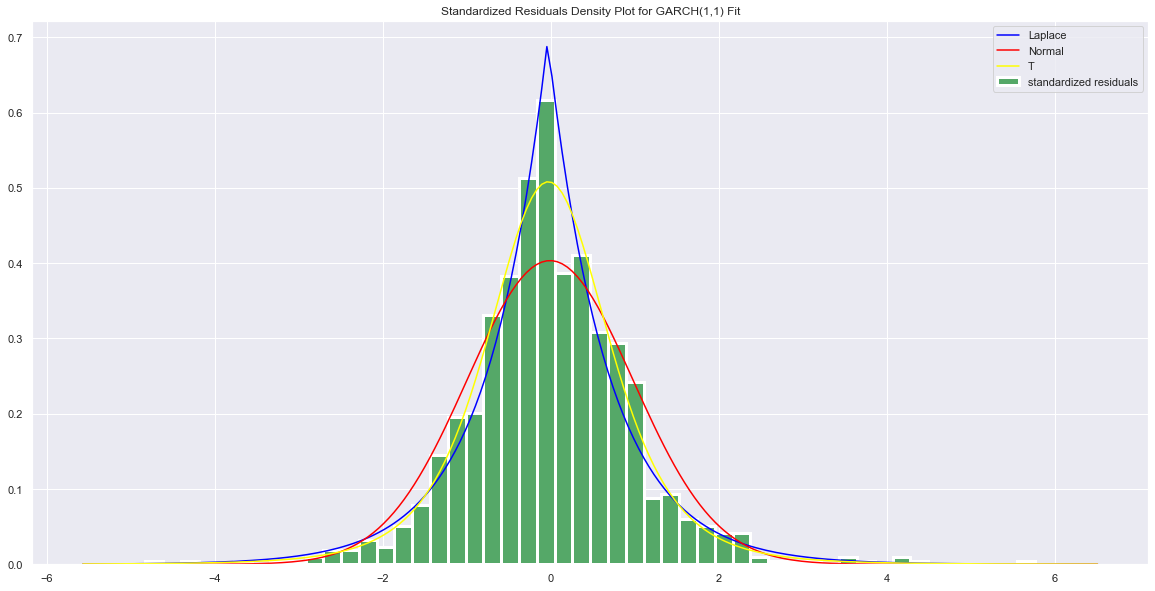

In [22]:
plt.figure(figsize=(20,10))
sns.distplot(omptimStdResid,fit_kws = {'color':'blue'},
             fit = stats.laplace, 
             bins = 50,
             hist_kws={"histtype": "bar",
                       "linewidth": 3,
                       "alpha": 1, 
                       "color": "g"}, 
             kde = False)
sns.distplot(omptimStdResid, fit_kws = {'color':'red'},
             fit = stats.norm, hist = False, kde = False)
sns.distplot(omptimStdResid,fit_kws = {'color':'yellow'},
             fit = stats.t, hist = False, kde = False)
plt.legend(('Laplace', "Normal", "T",'standardized residuals'))
plt.title("Standardized Residuals Density Plot for GARCH(1,1) Fit")
plt.show()

# Moving On to Fitting Model Over Residuals

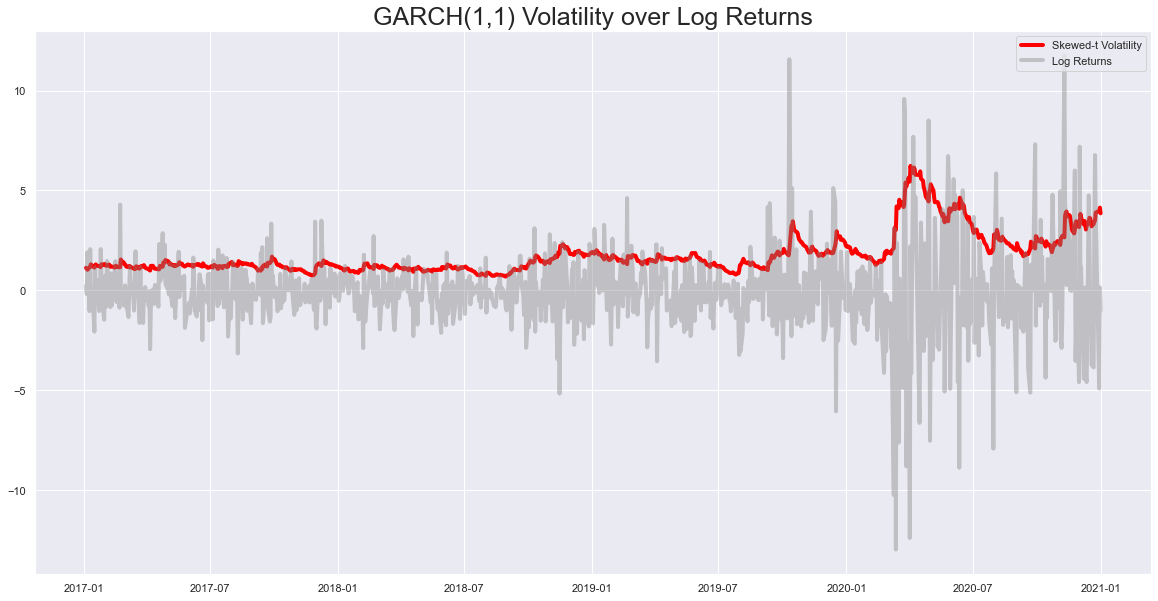

In [23]:
plt.figure(figsize=(20,10))
plt.plot(optimStd, color = 'red', label = 'Skewed-t Volatility', linewidth = 4)
plt.plot(priceData['logReturn'], color = 'grey', 
         label = 'Log Returns', alpha = 0.4, linewidth =4)
plt.title("GARCH(1,1) Volatility over Log Returns",
         fontsize = 25)
plt.legend(loc = 'upper right')
plt.show()

## Evaluating With Metrics

In [18]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [19]:
def evaluate(observation, forecast): 
    # Call sklearn function to calculate MAE
    mae = mean_absolute_error(observation, forecast)
    print(f'Mean Absolute Error (MAE): {round(mae,3)}')
    # Call sklearn function to calculate MSE
    mse = mean_squared_error(observation, forecast)
    print(f'Mean Squared Error (MSE): {round(mse,3)}')
    return mae, mse

# Backtest model with MAE, MSE
evaluate(priceData['logReturn'].sub(priceData['logReturn'].mean()).pow(2), optimStd**2)



NameError: name 'optimStd' is not defined

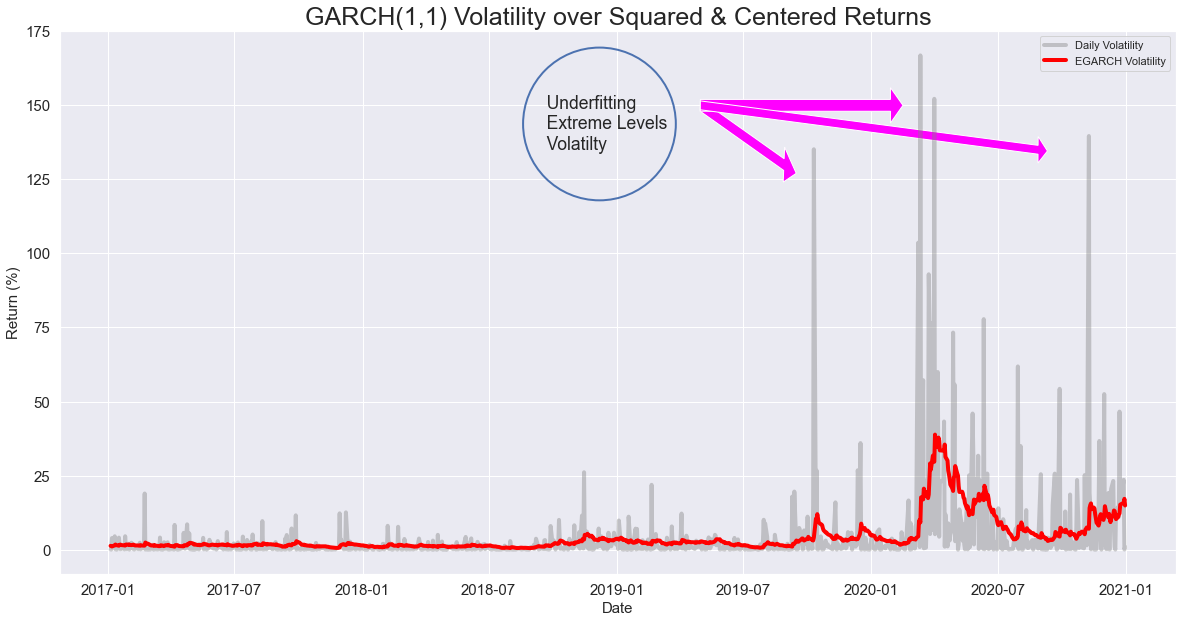

In [26]:
# Plot the actual volatility
plt.figure(figsize=(20,10))
plt.plot(priceData['logReturn'].sub(priceData['logReturn'].mean()).pow(2), 
         color = 'grey', alpha = 0.4, label = 'Daily Volatility',
        linewidth = 4)
# Plot EGARCH  estimated volatility
plt.plot(optimStd**2, color = 'red', label = 'EGARCH Volatility', linewidth = 4)
plt.legend(loc = 'upper right')
plt.title("GARCH(1,1) Volatility over Squared & Centered Returns",
         fontsize = 25)
plt.arrow(x=dt.datetime(2019,5,1), y=150, dx=dt.datetime(1970,5,1), dy=-20, width = 4, facecolor = 'magenta')
plt.arrow(x=dt.datetime(2019,5,1), y=150, dx=dt.datetime(1970,10,1), dy=0, width = 4, facecolor = 'magenta')
plt.arrow(x=dt.datetime(2019,5,1), y=150, dx=dt.datetime(1971,5,1), dy=-15, width = 3, facecolor = 'magenta')
plt.annotate('   Underfitting \n   Extreme Levels\n   Volatilty', xy = (dt.datetime(2018,9,1), 135), fontsize = 17.5,
                bbox=dict(boxstyle="circle,pad=0.5", fc="none", ec="b", lw=2))
plt.xticks(fontsize =15)
plt.yticks(fontsize =15)
plt.ylabel('Return (%)',fontsize =15)
plt.xlabel('Date',fontsize =15)
plt.show()

# Comparing 
## Rolling Window
## Expanding Window

In [9]:
index = priceData.index
start_loc = 0
end_loc = np.where(index >= '2020-1-1')[0].min()
forecasts = {}
windowLength = 252

In [10]:
for i in range(windowLength):
    sys.stdout.write("-__-")
    sys.stdout.flush()
    res = optimModel.fit(first_obs=start_loc + i, last_obs=i + end_loc, disp='off')
    temp = res.forecast(horizon=1).variance
    fcast = temp.iloc[i + end_loc - 1]
    forecasts[fcast.name] = fcast
print(' Done!')
variance_fixedwin = pd.DataFrame(forecasts).T

-__--__--__--__--__--__-

C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After Se

-__--__--__--__--__-

C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After Se

-__--__--__--__-

C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After Se

-__--__--__--__-

C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After Se

-__--__--__--__--__-

C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After Se

-__--__--__--__--__-

C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After Se

-__--__--__--__--__-

C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After Se

-__--__--__--__--__-

C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After Se

-__--__--__--__--__-

C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After Se

-__--__--__--__-

C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After Se

-__--__--__--__--__-

C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After Se

-__--__--__--__--__--__-

C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After Se

-__--__--__--__--__--__-

C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After Se

-__--__--__--__--__-

C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After Se

-__--__--__--__--__--__-

C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After Se

-__--__--__--__--__-

C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After Se

-__--__--__--__--__--__-

C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After Se

-__--__--__--__--__--__-

C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After Se

-__--__--__--__--__-

C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After Se

-__--__--__--__--__-

C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After Se

-__--__--__--__--__-

C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After Se

-__--__--__--__--__--__-

C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After Se

-__--__--__--__--__--__-

C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After Se

-__--__--__--__--__--__-

C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After Se

-__--__--__--__--__--__-

C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After Se

-__--__--__--__--__-

C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After Se

-__--__--__--__--__-

C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After Se

-__--__--__--__--__-

C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After Se

-__--__--__--__-

C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After Se

-__--__--__-

C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After Se

-__--__--__--__-

C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After Se

-__--__--__--__--__-

C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After Se

-__--__--__--__-

C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After Se

-__--__--__--__-

C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After Se

-__--__--__--__--__-

C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After Se

-__--__--__--__-

C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After Se

-__--__--__--__--__-

C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After Se

-__--__--__--__--__-

C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After Se

-__--__--__--__--__-

C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After Se

-__--__--__--__--__-

C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After Se

-__--__--__--__--__-

C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After Se

-__--__--__--__--__-

C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After Se

-__--__--__--__-

C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After Se

-__--__--__--__--__--__-

C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After Se

-__--__--__--__--__-

C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After Se

-__--__--__--__--__-

C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After Se

-__--__--__--__--__-

C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After Se

-__--__--__--__-

C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After Se

-__--__--__--__--__--__-

C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After Se

-__--__--__--__--__-

C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After Se

-__--__- Done!


C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After Se

In [11]:
for i in range(windowLength):
    sys.stdout.write(":-)"+ ", ")
    sys.stdout.flush()
    res = optimModel.fit(first_obs = start_loc, last_obs = i + end_loc, disp = 'off')
    temp = res.forecast(horizon=1).variance
    fcast = temp.iloc[i + end_loc - 1]
    forecasts[fcast.name] = fcast
print(' Done!')
variance_expandwin = pd.DataFrame(forecasts).T

:-), :-), :-), :-), :-), :-), 

C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After Se

:-), :-), :-), :-), :-), 

C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After Se

:-), :-), :-), :-), :-), 

C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After Se

:-), :-), :-), :-), :-), 

C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After Se

:-), :-), :-), :-), 

C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After Se

:-), :-), :-), :-), 

C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After Se

:-), :-), :-), 

C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After Se

:-), :-), :-), 

C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After Se

:-), :-), :-), 

C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After Se

:-), :-), :-), 

C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After Se

:-), :-), :-), 

C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After Se

:-), :-), :-), 

C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After Se

:-), :-), :-), 

C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After Se

:-), :-), :-), 

C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After Se

:-), :-), :-), :-), 

C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After Se

:-), :-), :-), :-), :-), 

C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After Se

:-), :-), :-), :-), :-), 

C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After Se

:-), :-), :-), :-), 

C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After Se

:-), :-), :-), :-), :-), 

C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After Se

:-), :-), :-), :-), :-), 

C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After Se

:-), :-), :-), :-), :-), 

C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After Se

:-), :-), :-), 

C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After Se

:-), :-), :-), :-), :-), :-), 

C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After Se

:-), :-), :-), :-), 

C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After Se

:-), :-), :-), :-), :-), 

C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After Se

:-), :-), :-), :-), :-), 

C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After Se

:-), :-), :-), :-), :-), :-), 

C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After Se

:-), :-), :-), :-), :-), 

C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After Se

:-), :-), :-), :-), :-), :-), 

C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After Se

:-), :-), :-), :-), :-), 

C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After Se

:-), :-), :-), :-), :-), 

C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After Se

:-), :-), :-), :-), :-), 

C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After Se

:-), :-), :-), :-), :-), 

C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After Se

:-), :-), :-), :-), :-), 

C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After Se

:-), :-), :-), :-), :-), 

C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After Se

:-), :-), :-), :-), :-), :-), 

C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After Se

:-), :-), :-), :-), :-), 

C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After Se

:-), :-), :-), :-), 

C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After Se

:-), :-), :-), :-), :-), 

C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After Se

:-), :-), :-), :-), :-), 

C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After Se

:-), :-), :-), :-), :-), 

C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After Se

:-), :-), :-), :-), :-), 

C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After Se

:-), :-), :-), :-), :-), 

C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After Se

:-), :-), :-), :-), :-), 

C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After Se

:-), :-), :-), :-), :-), 

C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After Se

:-), :-), :-), :-), 

C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After Se

:-), :-), :-), :-), :-), 

C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After Se

:-), :-), :-), :-), :-), 

C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After Se

:-), :-), :-), :-), :-), 

C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After Se

:-), :-), :-), :-), :-), 

C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After Se

:-), :-), :-), :-), :-), 

C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After Se

:-), :-), :-), :-), :-), 

C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After Se

:-), :-), :-), :-), 

C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After Se

:-), :-), :-), :-), :-), 

C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After Se

:-), :-), :-),  Done!


C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After Se

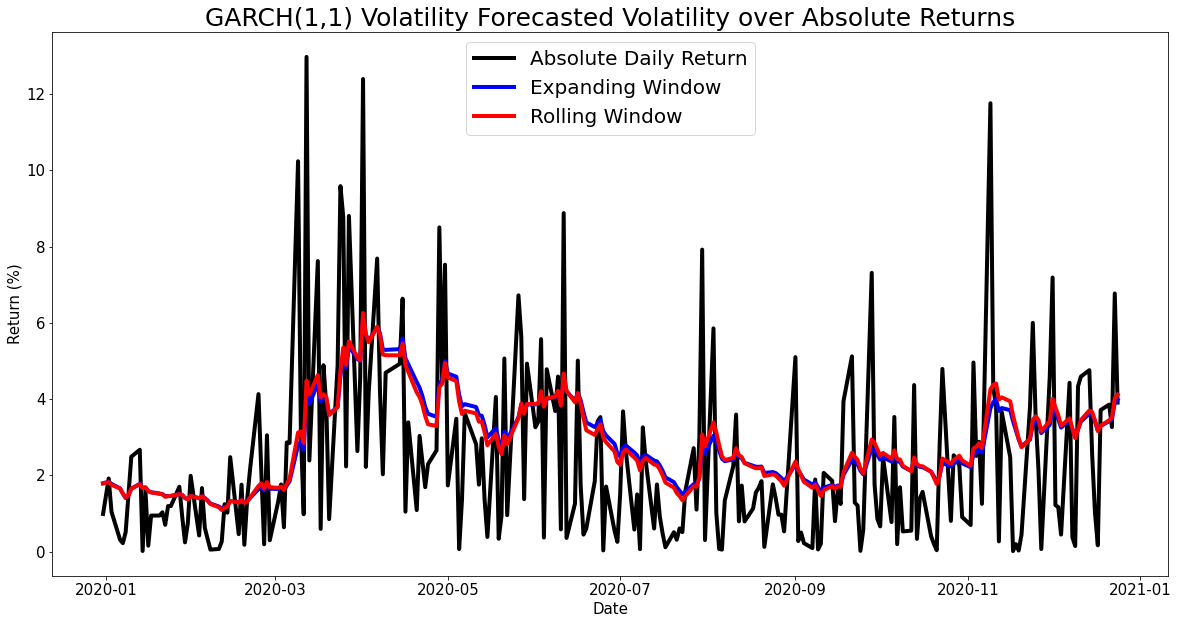

In [13]:
# Calculate volatility from variance forecast with an expanding window
vol_expandwin = np.sqrt(variance_expandwin)

# Calculate volatility from variance forecast with a fixed rolling window
vol_fixedwin = np.sqrt(variance_fixedwin)

# Plot results
plt.figure(figsize=(20,10))

plt.plot(abs(priceData.logReturn.loc[variance_expandwin.index]), 
         color = 'black', 
         label='Absolute Daily Return',
        linewidth = 4)
# Plot volatility forecast with an expanding window
plt.plot(vol_expandwin, color = 'blue', label='Expanding Window',
        linewidth = 4)

# Plot volatility forecast with a fixed rolling window
plt.plot(vol_fixedwin, color = 'red', label='Rolling Window',
        linewidth = 4)
plt.title("GARCH(1,1) Volatility Forecasted Volatility over Absolute Returns",
         fontsize = 25)

plt.xticks(fontsize =15)
plt.yticks(fontsize =15)
plt.ylabel('Return (%)',fontsize =15)
plt.xlabel('Date',fontsize =15)
plt.legend(loc = 'best',
          fontsize = 20)
plt.show()


# Backtesting

In [14]:
testData = priceData.logReturn.loc[variance_expandwin.index]
sqctest = testData.sub(testData.mean()).pow(2)
expandSq = vol_expandwin**2
fixedSq = vol_fixedwin**2

In [28]:
expand = evaluate(sqctest, expandSq)

Mean Absolute Error (MAE): 9.839
Mean Squared Error (MSE): 410.723


In [29]:
fixed = evaluate(sqctest, fixedSq)

Mean Absolute Error (MAE): 9.609
Mean Squared Error (MSE): 392.288


╒═══════════════════╤═══════════════════╕
│ Forecast          │ MAE               │
╞═══════════════════╪═══════════════════╡
│ Expanding         │ Fixed             │
├───────────────────┼───────────────────┤
│ 9.839073685494293 │ 410.7229794439701 │
├───────────────────┼───────────────────┤
│ 9.609498844593505 │ 392.2880294197995 │
╘═══════════════════╧═══════════════════╛


In [49]:
combo['indextest'] = indextest
print(tabulate(combo,
               headers=col_names,
               tablefmt="fancy_grid", showindex="never"))

╒════════════╤═════════╤═══════════╕
│   Forecast │     MAE │ MSE       │
╞════════════╪═════════╪═══════════╡
│    9.83907 │ 410.723 │ Expanding │
├────────────┼─────────┼───────────┤
│    9.6095  │ 392.288 │ Fixed     │
╘════════════╧═════════╧═══════════╛


# Bringing In Irithmics to try and merge the data
#### This is from the other file

In [35]:
Irithmics = pd.read_csv('agg.csv')
Irithmics = Irithmics[['Date', 'shortProb']]
Irithmics['Date'] = pd.to_datetime(Irithmics['Date'])
Irithmics =Irithmics.set_index('Date')
Irithmics.head()

,shortProb
Date,
2020-01-02,0.025995
2020-01-03,0.022662
2020-01-06,0.013997
2020-01-07,0.003999
2020-01-08,0.002200


In [37]:
#Implementing the found model above
irithModel = arch_model(Irithmics['shortProb'].mul(100),
                       p = 1,
                       q = 1,
                       mean = 'constant',
                       vol = 'EGARCH',
                       dist = 'skewt')
irithRes = irithModel.fit(disp = False)
irithResid = irithRes.resid
irithStd = irithRes.conditional_volatility
irithStdResid = irithResid/irithStd

In [38]:
from fitter import Fitter, get_common_distributions, get_distributions

In [40]:
f = Fitter(irithStd**2,
           distributions= get_common_distributions())
f.fit()
f.get_best(method = 'sumsquare_error')

{'lognorm': {'s': 1.3421675436962222,
  'loc': 0.012122929618877658,
  'scale': 0.291280849709139}}

In [44]:
len(irithStd)
np.random.lognormal(f.get_best(method = 'sumsquare_error')["lognorm"]['loc'],
                           np.array(optimStd**2)[i],
                           1)[0]

0.6302941398333854

In [54]:
sampledDist = [0 for a in range(len(irithStd**2))]
for i in range(len(irithStd**2)):
    sampledDist[i] = (np.random.lognormal(f.get_best(method = 'sumsquare_error')["lognorm"]['loc'],
                           np.array(irithStd**2)[i],
                           1)[0])

In [55]:
sampledDist = np.array(sampledDist)
centeredSample = sampledDist - mean(sampledDist)

In [72]:
len(centeredSample[-len(centeredSample)+1:])

252

In [125]:
vol_expandwin['Irithmics'] = centeredSample[-len(centeredSample)+1:]/100
vol_expandwin['Combined'] = vol_expandwin['Irithmics']+vol_expandwin['h.1']


In [123]:
vol_expandwin.max()

h.1            6.124727
Irithmics    303.829867
Combined       6.631100
dtype: float64

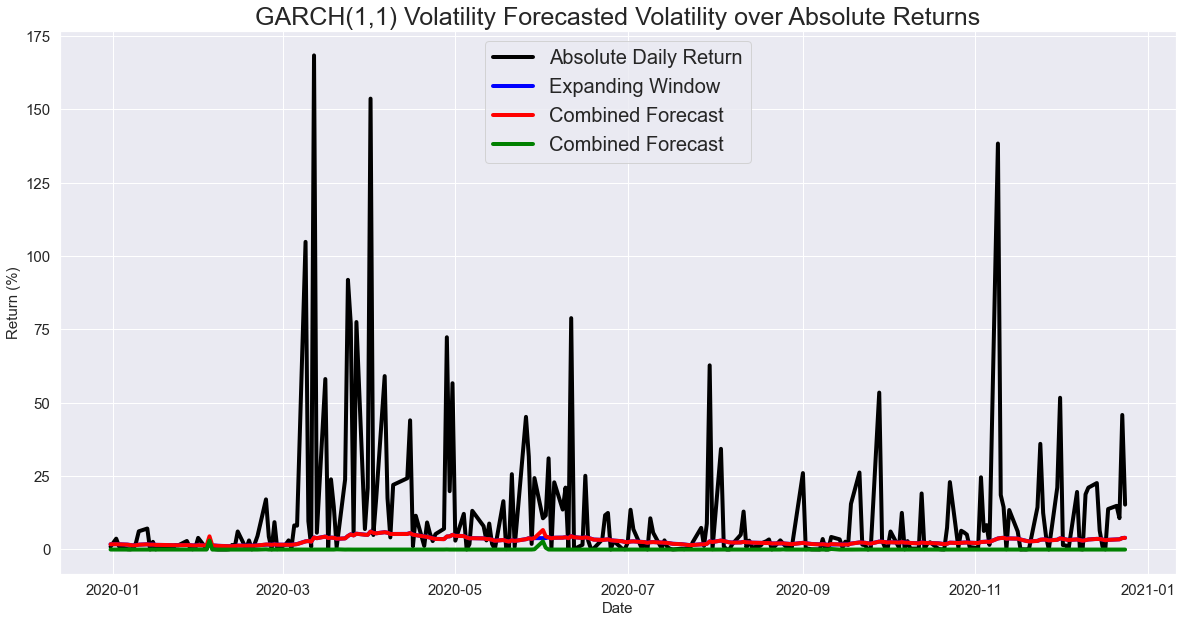

In [128]:
# Plot results
plt.figure(figsize=(20,10))

plt.plot(priceData.logReturn.loc[variance_expandwin.index]**2, 
         color = 'black', 
         label='Absolute Daily Return',
        linewidth = 4)
# Plot volatility forecast with an expanding window
plt.plot(vol_expandwin['h.1'], color = 'blue', label='Expanding Window',
        linewidth = 4)

# Plot volatility forecast with a fixed rolling window
plt.plot(vol_expandwin['Combined'], color = 'red', label='Combined Forecast',
        linewidth = 4)

plt.plot(vol_expandwin['Irithmics'], color = 'green', label='Combined Forecast',
        linewidth = 4)

plt.title("GARCH(1,1) Volatility Forecasted Volatility over Absolute Returns",
         fontsize = 25)

plt.xticks(fontsize =15)
plt.yticks(fontsize =15)
plt.ylabel('Return (%)',fontsize =15)
plt.xlabel('Date',fontsize =15)
plt.legend(loc = 'best',
          fontsize = 20)
plt.show()

# Bootstrapping the Forecasts 

In [311]:
# The paths for the final observation
sim_forecasts = optimRes.forecast(horizon=5, method='simulation')
sim_paths = sim_forecasts.simulations.residual_variances[-1].T
sim = sim_forecasts.simulations

bs_forecasts = optimRes.forecast(horizon=5, method='bootstrap')
bs_paths = bs_forecasts.simulations.residual_variances[-1].T
bs = bs_forecasts.simulations

array([[13.45006977, 13.45006977, 13.45006977, ..., 13.45006977,
        13.45006977, 13.45006977],
       [11.9030138 , 14.07266947, 11.65030286, ..., 16.12479713,
        13.1560363 , 13.15081811],
       [11.07403681, 17.38449227, 13.42093084, ..., 16.13479144,
        15.36858758, 11.35439614],
       [ 9.68403502, 19.75166033, 12.01335743, ..., 14.42163137,
        14.92174045, 12.06218847],
       [ 9.22825084, 22.37645719, 10.76677409, ..., 13.44080049,
        16.54402548, 11.04442562]])

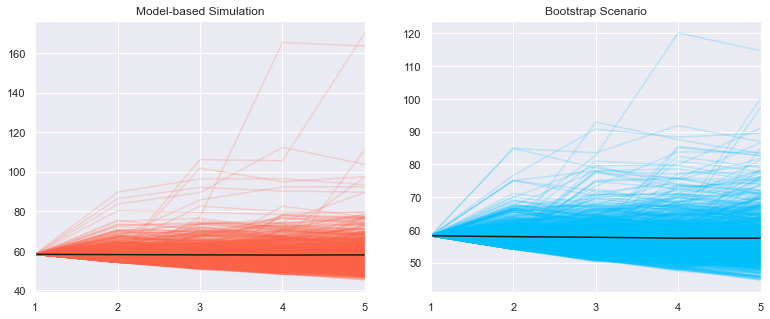

In [312]:
fig, axes = plt.subplots(1, 2, figsize=(13,5))

x = np.arange(1, 6)

# Plot the paths and the mean, set the axis to have the same limit
axes[0].plot(x, np.sqrt(252 * sim_paths), color='tomato', alpha=0.2)
axes[0].plot(x, np.sqrt(252 * sim_forecasts.residual_variance.iloc[-1]),
    color='k', alpha=1)

axes[0].set_title('Model-based Simulation')
axes[0].set_xticks(np.arange(1, 6))
axes[0].set_xlim(1, 5)

axes[1].plot(x, np.sqrt(252 * bs_paths), color='deepskyblue', alpha=0.2)
axes[1].plot(x,np.sqrt(252 * bs_forecasts.residual_variance.iloc[-1]),
    color='k', alpha=1)

axes[1].set_xticks(np.arange(1, 6))
axes[1].set_xlim(1, 5)

axes[1].set_title('Bootstrap Scenario')
plt.show()

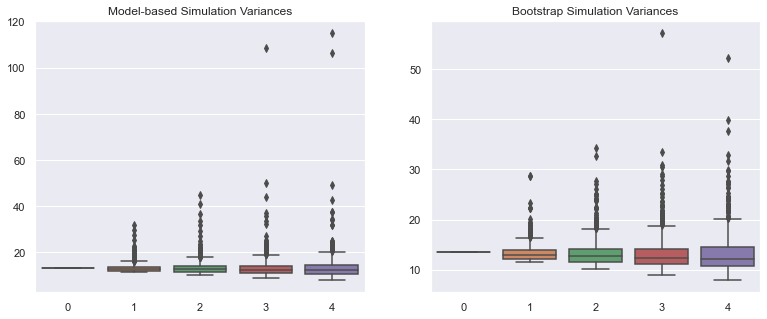

In [313]:


# Plot Simulation Variances
fig, axes = plt.subplots(1, 2, figsize=(13,5))

sns.boxplot(data=sim.variances[-1], ax=axes[0])
sns.boxplot(data=bs.variances[-1], ax=axes[1])

axes[0].set_title('Model-based Simulation Variances')
axes[1].set_title('Bootstrap Simulation Variances')

plt.show()

